# **Cityscapes Dataset**

In this notebook we will explore the cityscapes dataset and build a pyorch dataloader for RGB, Depth, and segmentation


Resource:
- https://www.cityscapes-dataset.com/
- https://arxiv.org/pdf/1604.01685.pdf
- https://github.com/mcordts/cityscapesScripts/tree/master
- https://github.com/mcordts/cityscapesScripts/blob/master/docs/csCalibration.pdf

In [5]:
import os
from glob import glob

import numpy as np
import h5py
import cv2

import torch 
from torch.utils.data import Dataset
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt



%matplotlib inline

## Load Dataset

We have stored the cityscapes data in the following structure

- cityscapes
    - disparity
        - train
        - val
        - test
    - gtFine
        - train
        - val
        - test
    - leftImg8bit
        - train
        - val
        - test

In [6]:
root = r"C:\Users\itber\Documents\datasets\cityscapes"

In [7]:
class CityScapes():
    def __init__(self, root, split='train', return_paths=False):
        self.root = root
        self.return_paths = return_paths

        self.rgb_paths = glob(os.path.join(root, 'leftImg8bit', split, '**\*.png'))
        self.mask_paths = glob(os.path.join(root, 'gtFine', split, '**\*labelIds.png'))
        self.disparity_paths = glob(os.path.join(root, 'disparity', split, '**\*.png'))


    def __getitem__(self, idx):
        rgb_image = cv2.cvtColor(cv2.imread(self.rgb_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_UNCHANGED)
        disparity = cv2.imread(self.disparity_paths[idx], cv2.IMREAD_UNCHANGED)

        if self.return_paths:
            return rgb_image, (mask, disparity), self.rgb_paths[idx], (self.mask_paths[idx], self.disparity_paths[idx])

        return rgb_image, (mask, disparity)
    
    def __len__(self):
        return len(self.rgb_paths)

### Initialize dataset and display an image

In [48]:
dataset = CityScapes(root, split='train')

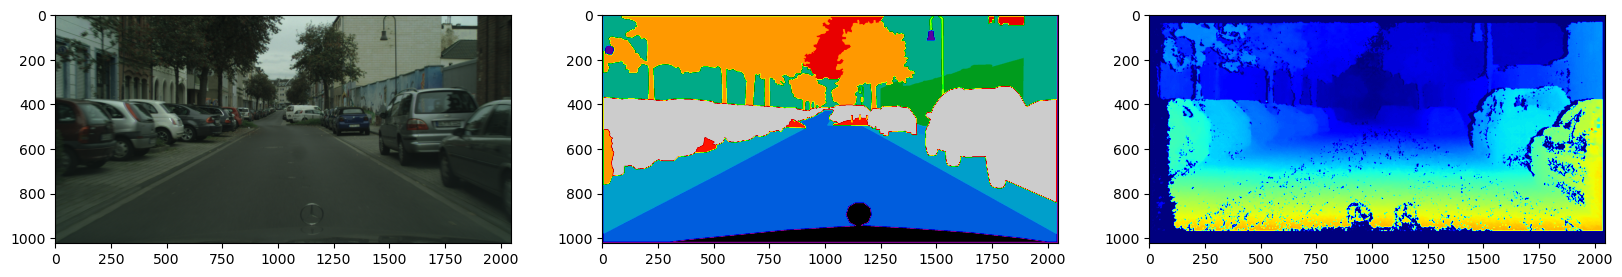

In [49]:
rgb_image, (mask, disparity) = dataset[130]

_, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(rgb_image)
ax[1].imshow(mask, cmap='nipy_spectral')
ax[2].imshow(disparity, cmap='jet')

## Make pipeline to obtain depthmaps

1. Crop noisy parts and resize (seems to be better than relecting on the borders)
    - This step introduces a very important caveat, for training a model it is absolutley necessary
    to preprocess every input image is this exact same manner! Or else we introduce bias into our model.
    And to further this, the bias is not very straight forward.
2. Inpaint and Blur disparity to reduce noise
3. Scale to get True disparity values
4. Compute depth $d = (b \cdot f) / \text{disparity}$
    - d: depth (meters), b: baseline (meters), f: focal length (pixels), disparity (pixels)
5. clip to (0, 500)

1. Crop noisy parts and resize

In [50]:
# get sizes
h, w = disparity.shape
h2, w2 = int(h*0.8), int(w*0.8)

# remove most noisy bottom area
# crop bottom noise and resize
disparity = cv2.resize(disparity[50:h2, 100:], (w,h))

# # remove noisy top and left areas with border replicate
# # crop top and left and use copyMakeBorder to replicate the edges
# disparity = cv2.copyMakeBorder(disparity[:, 50:], 
#                                top=0, 
#                                bottom=0, 
#                                left=50, 
#                                right=0, 
#                                borderType=cv2.BORDER_REFLECT)

2. Inpaint invalid Disparity and blur to further reduce the noise

In [51]:
# inpaint invalid disparity
inpaint_radius = 12
disparity = cv2.inpaint(disparity, np.uint8(255*(disparity <= 1)), inpaintRadius=inpaint_radius, flags=cv2.INPAINT_TELEA)

# blur to reduce noise
disparity = cv2.medianBlur(disparity, 5)

3. Scale to get true disparity

In [52]:
disparity = disparity.astype(np.float32)
disparity[disparity > 0] = (disparity[disparity > 0] - 1) / 256

4. Compute depth

In [53]:
baseline = 0.209313 # meters

# focal lengths (pixels)
fx = 2262.52 
fy = 2265.3017905988554 

depth = baseline * fx / (disparity + 0.1)

5. Clip to (0, 500)

In [54]:
depth = np.clip(depth, 0, 500)

Display 

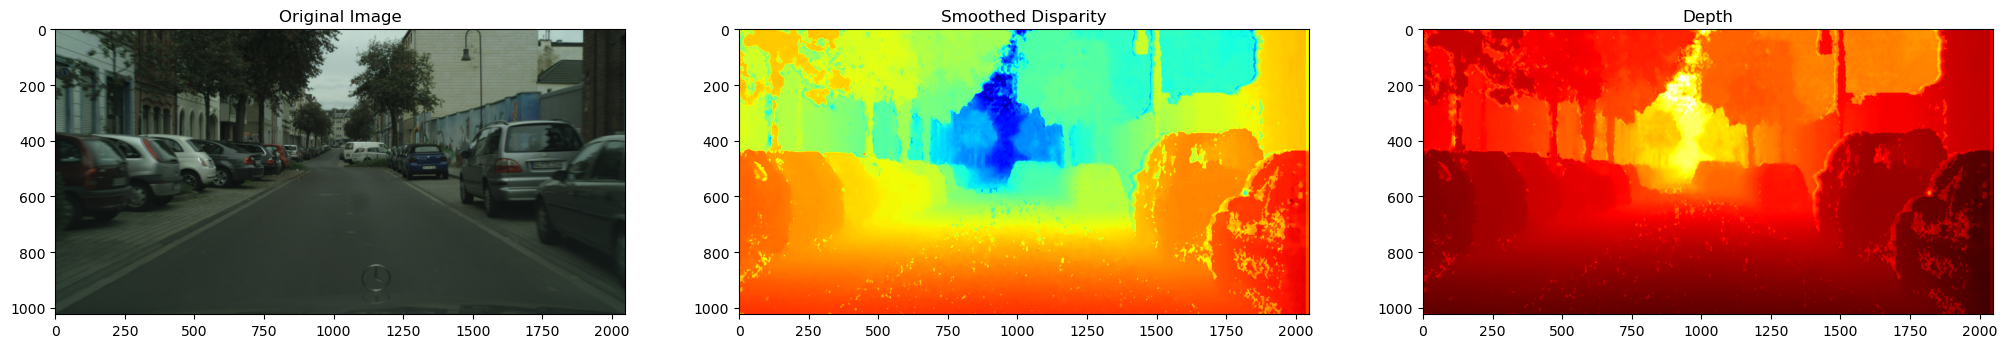

In [55]:
_, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(rgb_image)
ax[0].set_title("Original Image")
ax[1].imshow(np.log(disparity + 1), cmap='jet')
ax[1].set_title("Smoothed Disparity")
ax[2].imshow(np.log(depth), cmap='hot')
ax[2].set_title("Depth");

Create full pipeline to convert disparity to depth maps

In [56]:
def compute_depth(disparity : np.ndarray, 
                  w : int = 2048, 
                  h : int = 1024, 
                  inpaint_radius : int = None, 
                  baseline : float = 0.209313, 
                  f : float = 2262.52, 
                  max_depth : int = 500) -> np.ndarray:
    """ Computes smooth depth map from disparity 
        Inputs:
            disparity - uint16 dispairty image, 
            w - disparity width, 
            h - disparity height, 
            inpaint_radius - inpainting radius, 
            baseline stereo baseline distance (meters), 
            f - camera focal length (pixels) 
                For CityScapes:
                    fx = 2262.52 
                    fy = 2265.3017905988554 
            max_depth - maximum valid depth (meters)
        Outputs: 
            depth - computed depth map
        """
    
    """ NOTE: For training, need to process all input images just like this! """
    # crop noisy areas and resize
    disparity = cv2.resize(disparity[50:int(h*0.8), 100:], (w,h))

    # inpaint invalid disparity
    if inpaint_radius:
        disparity = cv2.inpaint(disparity, 
                                np.uint8(255*(disparity <= 1)), 
                                inpaintRadius=inpaint_radius, 
                                flags=cv2.INPAINT_TELEA)

    # blur to reduce noise
    disparity = cv2.medianBlur(disparity, 5)

    # scale to get True Disparity
    disparity = disparity.astype(np.float32)
    disparity[disparity > 0] = (disparity[disparity > 0] - 1) / 256

    # compute depth
    depth = baseline * f / (disparity + 0.1)

    # clip and return
    return np.clip(depth, 0, max_depth)

In [57]:
dataset = CityScapes(root, split='train', return_paths=True)

In [58]:
rgb_image, (_, disparity), _, (_, disparity_path) = dataset[130]

In [59]:
# compute depth
disp = disparity.astype(np.float32)
disp[disp > 0] = (disp[disp > 0] - 1) / 256
og_depth =  0.209313 * 2262.52 / (disp + 0.1)


# compute smoothed depth
depth1 = compute_depth(disparity)
depth2 = compute_depth(disparity, inpaint_radius=12)

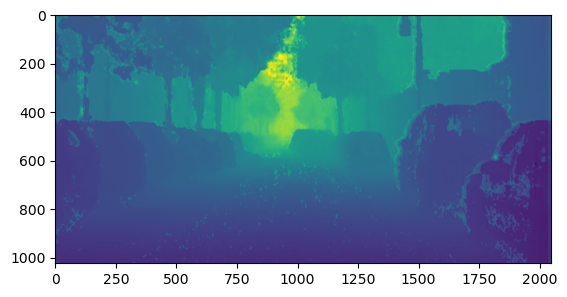

In [60]:
plt.imshow(np.log(depth2))

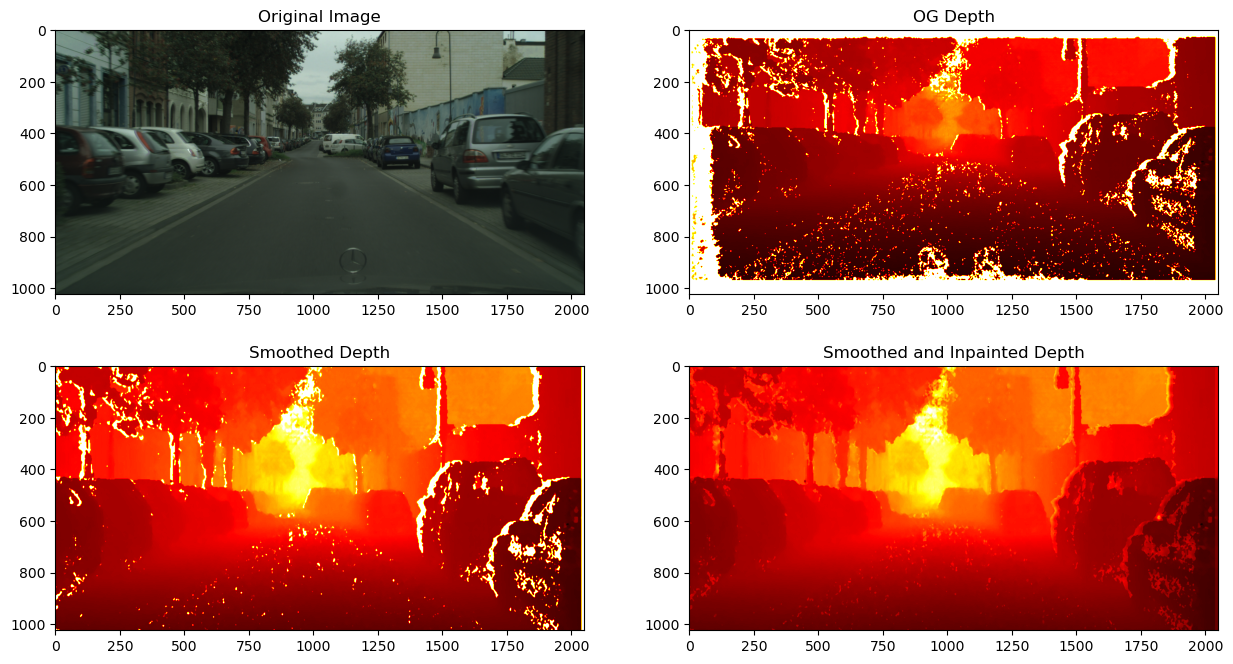

In [44]:
_, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0, 0].imshow(rgb_image)
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(np.log(og_depth), cmap='hot')
ax[0, 1].set_title("OG Depth")
ax[1, 0].imshow(np.log(depth1), cmap='hot')
ax[1, 0].set_title("Smoothed Depth")
ax[1, 1].imshow(np.log(depth2), cmap='hot')
ax[1, 1].set_title("Smoothed and Inpainted Depth");

In [672]:
disparity_path.replace('disparity', 'depth')

'C:\\Users\\itber\\Documents\\datasets\\cityscapes\\depth\\train\\aachen\\aachen_000130_000019_depth.png'

In [674]:
dirpath = os.path.basename(disparity_path.replace('disparity', 'depth'))
dirpath

'aachen_000130_000019_depth.png'

In [679]:
dirpath, name = os.path.split(disparity_path.replace('disparity', 'depth'))
dirpath, name

('C:\\Users\\itber\\Documents\\datasets\\cityscapes\\depth\\train\\aachen',
 'aachen_000130_000019_depth.png')

In [677]:
os.path.exists(dirpath)

False

In [682]:
try:
    os.mkdir(dirpath)
except:
    try:
        os.mkdir(os.path.split(dirpath)[0])
    except:
        os.mkdir(os.path.split(os.path.split(dirpath)[0])[0])

Create Depth maps for all training images

In [683]:
# create depth folder
depth_folder = os.path.join(root, 'depth')
if not os.path.exists(depth_folder):
    os.mkdir(depth_folder)

In [792]:
for split in ('train', 'val', 'test'):
    # create dir for split
    split_dir = os.path.join(depth_folder, split)
    if not os.path.exists(split_dir):
        os.mkdir(split_dir)

    # get dataset
    dataset = CityScapes(root, split=split, return_paths=True)

    # get depth map for all disparities
    for i in range(len(dataset)):
        _, (_, disparity), _, (_, disparity_path) = dataset[i]
        depth = compute_depth(disparity)

        savepath = disparity_path.replace('disparity', 'depth')
        dirname, _= os.path.split(savepath)
        if not os.path.exists(dirname):
            os.mkdir(dirname)

        cv2.imwrite(savepath, depth)

        break


    break